<div class="image-container">
  <img class="image" src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Logo-ITESO-Vertical-SinFondo-png.png" width="300" height="300">
</div>

### GAN PROYECT


#### Collaborators:
- Jesús Emilio Bravo Lizarraga
- María José Elizalde Arroyo
- María Fernanda Ramírez Montejano
- Enrique Jair Rodriguez Orozco

**Project Objective**

The primary objective of this project is to develop and evaluate a financial prediction strategy using a Generative Adversarial Network (GAN). Through this neural network architecture, comprising a generator and a discriminator, the aim is to create a model capable of generating synthetic data that mimics the behavior of real financial time series, such as stock prices or market indices.

This approach enables the achievement of the following specific objectives:

Train a generative model that, by learning historical patterns from financial data, can produce time series that accurately simulate market behavior. This provides a foundation for conducting simulations and predictions under controlled conditions.

Develop and optimize a trading strategy using the generated data, with the application of backtesting techniques to measure the strategy's performance in simulated scenarios. The model will assess the viability of different investment approaches by testing its ability to identify buying and selling opportunities based on price patterns.

Calculate and analyze performance metrics such as the Sharpe ratio, maximum drawdown, and Calmar ratio, which help evaluate the risk-adjusted performance of the proposed strategy. These metrics are essential for determining the effectiveness and stability of the strategy in conditions similar to those of a real market environment.

In sum, this project proposes the use of GANs to improve prediction quality and risk management in investment strategies. The results obtained will provide insight into the feasibility of employing generative models to create robust trading strategies based on simulated data, with practical applications for financial decision-making in dynamic and complex markets.

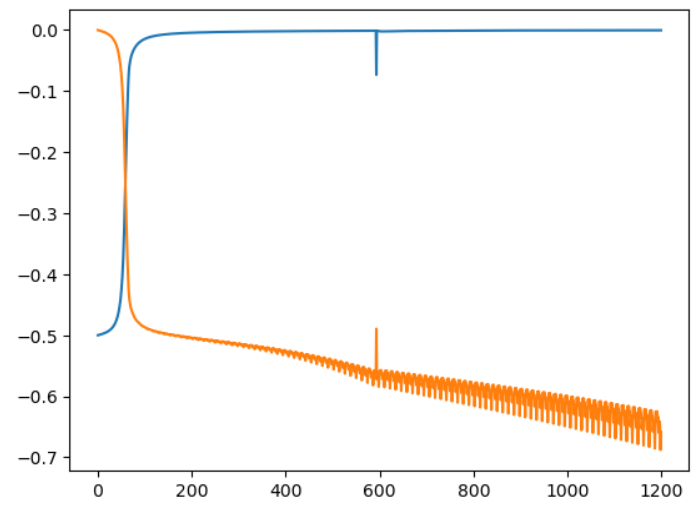

In GANs, there are two main components:

**Generator (gen):** This component attempts to create data that resembles real data.

**Discriminator (disc):** This component tries to distinguish between real data and data generated by the generator.

During training, both models "compete" against each other, meaning that the generator tries to minimize its loss (gen_loss) by improving its generated data, while the discriminator tries to minimize its own loss (disc_loss) by improving its ability to distinguish fake data from real data.

**Graph:**

Blue Line (gen_loss_history): Represents the generator’s loss over time. We observe that it starts with a high loss but quickly drops and stabilizes, indicating that the generator has learned to produce data increasingly similar to the real data.

Orange Line (disc_loss_history): Represents the discriminator’s loss. Its behavior seems to decline initially and then fluctuates, remaining at a low level, which indicates that the discriminator becomes more efficient at detecting generated data.

**Additional Observations**

The fluctuation in losses suggests that both models continue improving in their "game" against each other. However, the generator appears to reach a stable level sooner than the discriminator, which continues with slight oscillations.

This behavior is common in GANs, as achieving stability and balance between both models is challenging and often results in fluctuations in losses.

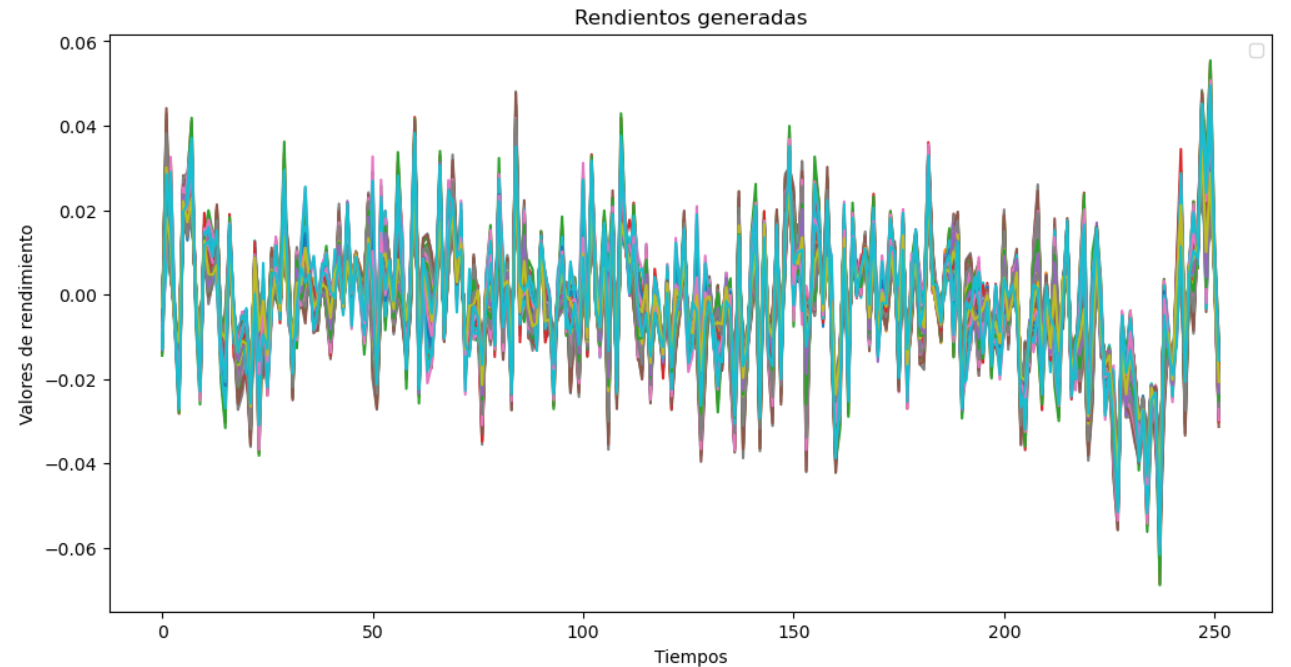

The graph shows multiple simulation lines over time, where:

**X-Axis (Time):** Represents the time horizon of the simulation, ranging from 0 to 250 periods, which may correspond to days, weeks, or any relevant unit of time for the analysis.

**Y-Axis (Performance Values):** Measures the estimated performance by the model at each time point, with values oscillating between -0.06 and 0.06. Positive values on the Y-axis suggest periods of gain, while negative values represent losses.

Each colored line in the graph represents an independent simulation of performance over the considered time period. This allows for visualization of the range of possible scenarios generated by the model.

The graph shows high variability among the different simulated scenarios, indicating that the model is capable of generating multiple performance trajectories with different patterns and amplitudes of oscillation.

The analysis of this graph indicates that the model is proficient in generating a diverse set of possible performance scenarios, which is useful for understanding the expected range of variability in the market.

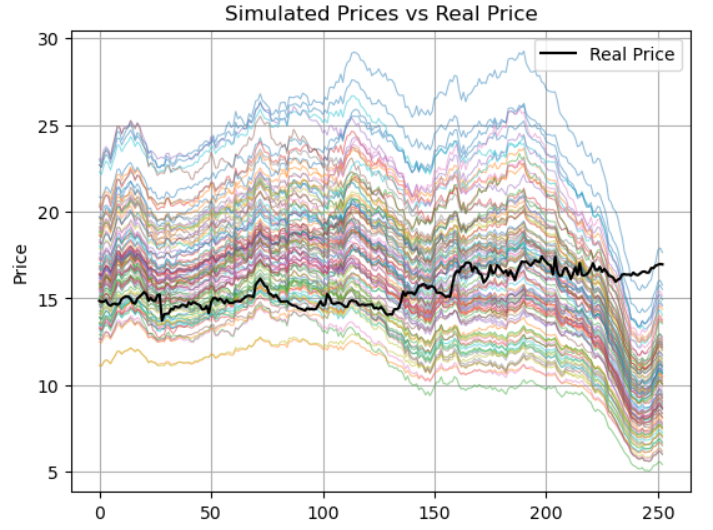

This graph presents a comparison between the simulated prices and the real price of a financial asset over a period of 250 time units.

**Analysis of the Results**

**Dispersion of the Simulations:**  
The simulations show a wide dispersion, especially toward the end of the period. At the beginning, most simulations are closer to the real price, which indicates that the model has greater accuracy in the short term.

As time progresses, the dispersion increases, suggesting that the model introduces greater uncertainty in the long term, generating scenarios that include both rising and falling prices. This is common in simulation models, as it is difficult to accurately predict price behavior over more distant periods.

**Comparison with the Real Price:**  
The real price line remains in the middle zone of the simulations, which is a good sign that the model is able to generate trajectories that reflect market reality to some extent.


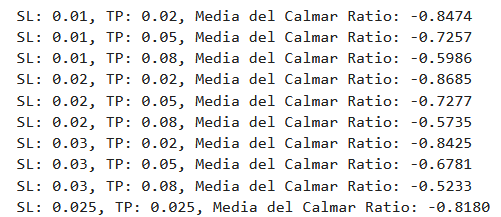

**Results Analysis:**

Optimization of the Calmar Ratio with Different Combinations of Stop Loss (SL) and Take Profit (TP)

This analysis evaluates the impact of different combinations of Stop Loss (SL) and Take Profit (TP) levels on the Average Calmar Ratio of a trading strategy. The Calmar Ratio is a key risk-return indicator that compares the annualized return of an investment with its maximum drawdown. A negative Calmar Ratio indicates that losses have exceeded returns, suggesting an unfavorable strategy in terms of risk-return.

**Interpretation of the Results**

**Patterns Observed in the Average Calmar Ratio:**  
The combinations of SL = 0.01 and TP = 0.02, 0.05, and 0.08 yield negative values in the Calmar Ratio, with results of -0.8474, -0.7257, and -0.5986, respectively. Although all are negative, the ratio slightly improves as the TP level increases, indicating that allowing more room for gains could reduce the negative impact on returns.

The values of SL = 0.02 also present negative ratios, being -0.8685, -0.7277, and -0.5735 for TP = 0.02, 0.05, and 0.08. As in the previous case, the Calmar Ratio improves as TP increases, suggesting that a broader profit target can moderate relative losses.

With SL = 0.03, the Calmar Ratio improves further, going from -0.8425 (TP = 0.02) to -0.6781 (TP = 0.05) and -0.5233 (TP = 0.08). This pattern suggests that a higher SL level combined with a higher TP could provide a more stable risk-return strategy.

Finally, with SL = 0.025 and TP = 0.025, the Average Calmar Ratio is -0.8180, placing it between the values of SL = 0.02 and SL = 0.03, but without standing out in terms of improvement.

Overall, increasing the Take Profit (TP) level has a positive effect on the Average Calmar Ratio, reducing the negative impact of losses on the strategy.

Lower Stop Loss values (e.g., SL = 0.01 and 0.02) tend to show more negative Calmar Ratios compared to an SL of 0.03, suggesting that a less restrictive strategy with the Stop Loss level may mitigate the frequency of losses.

The combination SL = 0.03 and TP = 0.08 shows the lowest negative average Calmar Ratio (-0.5233), making it the configuration that best optimizes the risk-return balance among those tested. This suggests that for this trading strategy, allowing a larger loss margin before exiting (Stop Loss) and setting a broad profit target (Take Profit) is more effective in terms of stability.

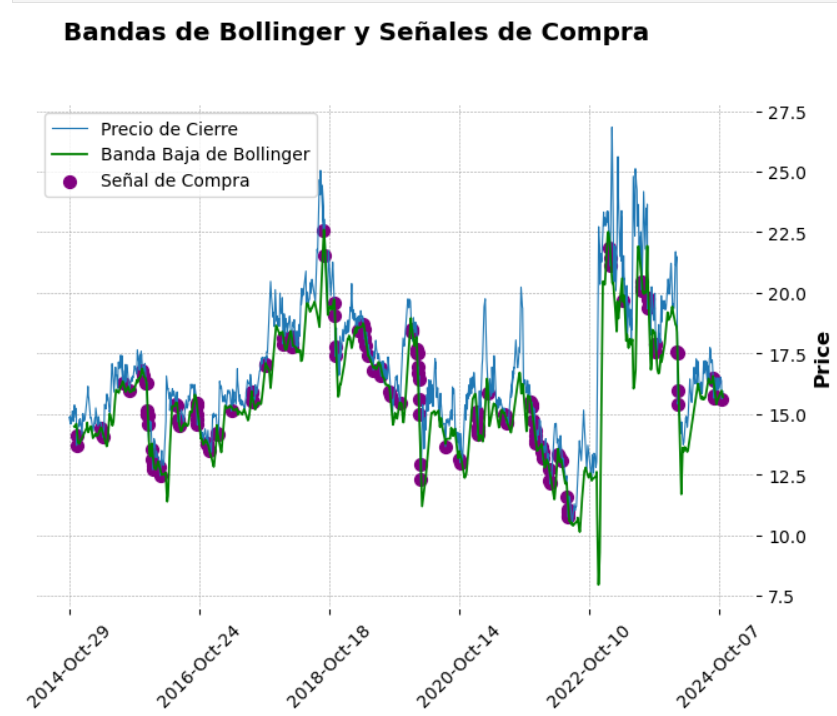

**Graph Analysis:**  
Bollinger Bands and Buy Signals

This graph shows the evolution of a financial asset's price along with Bollinger Bands and generated Buy Signals over a period of several years (from 2014 to 2024). Bollinger Bands are a technical indicator that helps identify overbought or oversold conditions, while buy signals represent moments when entering a long position is considered favorable.

**Closing Price (Blue Line):**  
Represents the asset's closing price on each date, capturing market fluctuations during the analyzed period. The price shows considerable volatility, with sharp peaks at certain moments and abrupt drops at others.

**Lower Bollinger Band (Green Line):**  
The Lower Bollinger Band is designed to capture potential oversold points. When the price falls below this band or touches it, it is often interpreted as a signal that the asset may be undervalued.  
In the graph, the closing price is observed to touch or approach this band on several occasions, especially during significant drops.

**Buy Signals (Purple Dots):**  
The purple dots indicate buy signals generated when the price reaches or crosses the Lower Bollinger Band, suggesting a possible buying opportunity based on an oversold criterion.  
The buy signals cluster in areas where the price has dropped considerably and recur at different points in the graph, reflecting entry points suggested by the indicator.

**Results Analysis**

**Behavior of Buy Signals in Relation to Price:**  
Buy signals occur primarily at the price’s local lows, which aligns with the Bollinger Bands’ approach to detecting oversold points. This indicates that the model is configured to take advantage of potential price rebounds after significant declines.  
In some cases, after a buy signal, the price increases, validating the indicator's utility for anticipating reversal points. However, there are moments when the signal is followed by further declines, suggesting that not all buy signals result in immediate upward movements.

**Price Variability and Bollinger Band:**  
During periods of high volatility, the price moves beyond the Lower Bollinger Band, and buy signals increase in frequency, indicating that the model detects more buying opportunities in unstable market scenarios.  
The Bollinger Band contracts and expands based on market volatility, adapting to price behavior and generating more spaced or frequent buy signals depending on the context.

**Long-Term Trends:**  
The graph shows phases of prolonged price increases (such as in 2021) and periods of decline (such as in 2022), during which buy signals are frequent in times of decline. This could imply that the model seeks to capture rebounds in bearish markets, taking advantage of price correction periods.

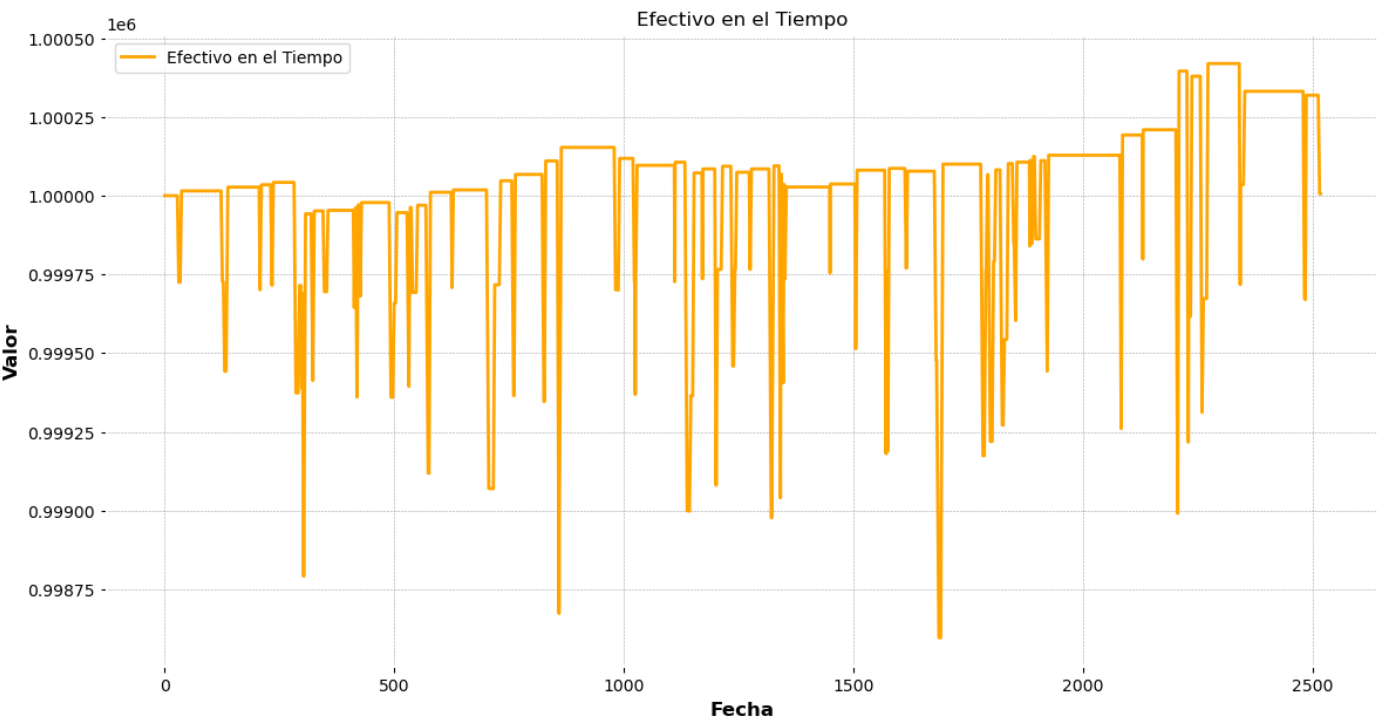

**Relationship Between the Graphs**

**Buy Signals and Cash Variations:**  
Each time the price reaches the Lower Bollinger Band and a buy signal is generated (purple dot in the first graph), the cash decreases in the second graph. This indicates that capital is invested in assets when buying opportunities are perceived based on oversold conditions.  
The sharp drops in cash in the second graph, therefore, correspond to moments when purchases are executed in response to these signals, which is consistent with the strategy of taking advantage of local lows.

**Cash Recovery:**  
After cash declines, the graph shows a partial or full recovery of capital, suggesting that positions are closed, allowing the invested capital to be regained. This may coincide with price increases following buy signals, which would be ideal in a trading strategy that seeks quick or short-term gains.

The overall stability of cash indicates that, as a whole, the strategy is able to maintain a balance between entries and exits, avoiding permanent losses in available capital.

**Strategy Evaluation:**  
The implementation of the strategy based on Bollinger Bands to identify entry points shows promising results in terms of consistency and risk control. The frequency of buy signals, combined with moderate cash fluctuations, demonstrates that the model applies Bollinger Bands effectively to detect buying opportunities.

A key result is that, although some buy signals are generated during periods when the price continues to decline, the cash balance shows a tendency to recover after each investment. This suggests that most trades have been profitable or, at the very least, have not generated significant losses, thus contributing to capital preservation.

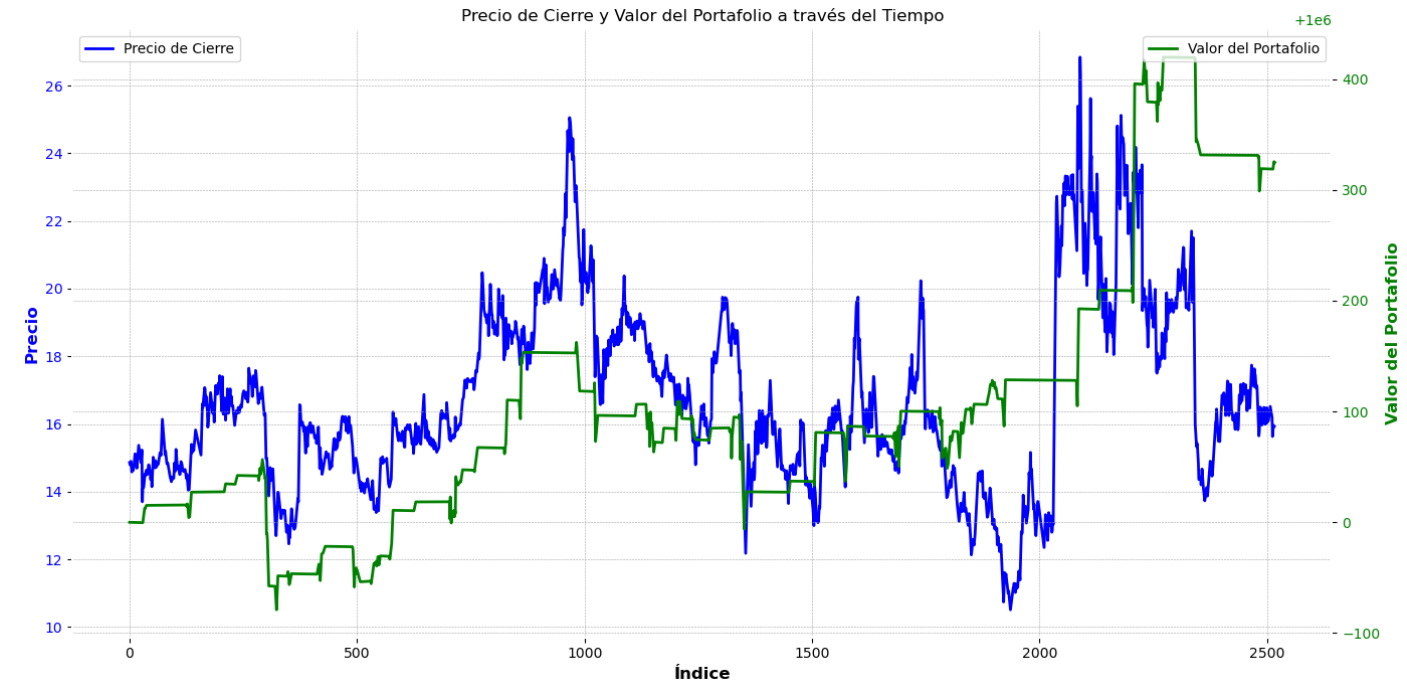

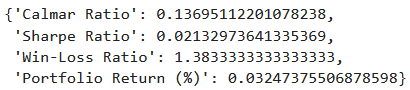

**Graph Analysis: Closing Price vs. Portfolio Value**

The graph compares the Closing Price of an asset (in blue) with the Portfolio Value (in green) over time. This analysis allows us to evaluate how the investment strategy responds to market fluctuations and how the portfolio value evolves in relation to the asset's price behavior.

**Closing Price Behavior:**  
The blue line represents the asset's closing price, showing several significant cycles of rise and fall over the period. This reflects the inherent volatility of the asset, with bullish and bearish trends in different time intervals.

**Portfolio Value Evolution:**  
The green line represents the accumulated value of the portfolio. The portfolio responds in a stepped manner, with increases at specific moments suggesting successful sales after reaching certain profit targets or predetermined exit points.  
Although the portfolio value shows increases, there are also periods of stability and slight decline, indicating that the strategy has been largely conservative and oriented toward capital protection during times of high volatility.

**Performance Metrics**

The results of the investment strategy are measured by the Calmar Ratio, Sharpe Ratio, Win-Loss Ratio, and Portfolio Return (%). These indicators help evaluate the balance between the strategy's performance and risk:

- **Calmar Ratio: 0.137**  
  This positive Calmar Ratio value indicates that the strategy has been able to generate a moderate return relative to the portfolio’s maximum drawdown. Although the value is relatively low, its positivity suggests that losses have been controlled in comparison to the returns obtained.

- **Sharpe Ratio: 0.021**  
  A positive, though low, Sharpe Ratio shows that the strategy has generated a return slightly above the risk-free rate, adjusted for portfolio volatility. This value suggests that the risk taken has been moderate and has generated minimal returns in terms of risk-adjusted profitability.

- **Win-Loss Ratio: 1.38**  
  The 1.38 ratio between winning and losing trades indicates that the strategy has had more successful trades than losses. This is a favorable result, as it shows that most buy and sell decisions have generated profits or, at least, minimized losses.

- **Portfolio Return (%): 0.032%**  
  The portfolio’s percentage return is positive but marginal (0.032%). This result confirms that the strategy managed to preserve capital and generate a very slight gain without taking significant risks.

**Conclusions**

The applied strategy has demonstrated a conservative approach with efficient risk management, keeping capital relatively stable and achieving a slight increase in portfolio value. Although the return has not been high, the loss control and favorable win-loss ratio suggest that the strategy is sustainable and may serve as a basis for future adjustments aimed at improving profitability.